<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
$\beta\beta0\nu$ Stuy </p><br>

## Study $\beta\beta0\nu$ reconstruction 

In [1]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### General

In [2]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
import functools
import time

from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import networkx as nx
from itertools   import combinations

In [3]:
from pandas import DataFrame, Series
from typing import List, Tuple
from typing import Union
from   dataclasses import dataclass

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [6]:
idx = pd.IndexSlice

#### IC

In [7]:

import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


#### TICs

In [8]:
from tics.histograms    import h1
from tics.pd_tics       import get_index_slice_from_multi_index
from tics.graphics_reco import plot_hits3d
from tics.stats_tics    import bin_data_with_equal_bin_size
from tics.util_tics import get_class_name
from tics.util_tics import Range
from tics.graphics_reco import plot_gtrack
from tics.system_of_units import *

#### NetFlex

In [9]:
from nextflex.core import Setup

In [10]:
from nextflex.core import Setup
from nextflex.mctrue_functions import get_mc_particles
from nextflex.mctrue_functions import get_mc_primary_particles
from nextflex.mctrue_functions import get_mc_vertex
from nextflex.mctrue_functions import select_mc_particles
from nextflex.mctrue_functions import get_mc_hits
from nextflex.mctrue_functions import select_mc_hits
from nextflex.mctrue_functions import total_hit_energy
from nextflex.mctrue_functions import get_event_hits_from_mchits

In [11]:
from nextflex.reco_functions import voxelize_hits
from nextflex.reco_functions import get_voxels_as_list
from nextflex.reco_functions import voxel_position
from nextflex.reco_functions import voxel_energy
from nextflex.reco_functions import voxel_nhits
from nextflex.reco_functions import distance_between_two_voxels
from nextflex.reco_functions import voxel_distances
from nextflex.reco_functions import voxel_distance_pairs
from nextflex.reco_functions import make_track_graphs
from nextflex.reco_functions import gtrack_voxels
from nextflex.reco_functions import shortest_paths
from nextflex.reco_functions import find_extrema_and_length
from nextflex.reco_functions import GTrack
from nextflex.reco_functions import voxels_in_blob
from nextflex.reco_functions import blob_energy
from nextflex.reco_functions import write_gtracks_json
from nextflex.reco_functions import load_gtracks_json

In [102]:
from nextflex.reco_analysis import reco_gtrack
from nextflex.reco_analysis import reco_gtrack
from nextflex.reco_analysis import reco_gtrack
from nextflex.reco_analysis import reco_gtrack_stats_histos
from nextflex.reco_analysis import reco_gtrack_timing_histos
from nextflex.reco_analysis import reco_gtrack_blobs
from nextflex.reco_analysis import reco_gtrack_blobs_histos
from nextflex.reco_analysis import TrackRecoStats
from nextflex.reco_analysis import TrackRecoTiming
from nextflex.reco_analysis import TrackRecoEventStats
from nextflex.reco_analysis import save_to_JSON
from nextflex.reco_analysis import load_from_JSON
from nextflex.reco_analysis import TrackRecoAnalysisSetup
from nextflex.reco_analysis import GtrkStats
from nextflex.reco_analysis import gtrack_summary

### Input data

In [13]:
FDATA = os.environ['FLEXDATA']

In [16]:
setup = Setup(flexDATA = FDATA,
              sipmPDE  = 1.0,
              maskPDE  = 1.0,
              qTh      = 0.0,
              tpConfig = "FLEX100_M6_O6_EL8bar_bb0nu")
print(setup)


        Setup <FLEX100_M6_O6_EL8bar_bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6_EL8bar_bb0nu
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu
        analysis directory           = /Users/jj/Development/flexdata/analysis/FLEX100_M6_O6_EL8bar_bb0nu
        number of h5 files in dir    = 208
        sipm map at                  = /Users/jj/Development/flexdata/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_EL8bar_bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.cs

In [17]:
ifnames = glob.glob(f"{FDATA}/{setup.tpConfig}/*.h5")
print(f'found {len(ifnames)} files')

found 208 files


### Run with large voxels

In [153]:
voxel_bin  = 5
contiguity =10

### Debug

In [174]:
gtrks, trackRecoStats, trackRecoEventStats, trackRecoTiming = reco_gtrack([ifnames[2]], 
                                                                          voxel_bin, 
                                                                          contiguity, 
                                                                          debug=True)

event list = [492 493 494 495]
event number = 1
 distance between voxels = [3.5283228  3.5283228  3.11373518 1.75400969 1.49295653 1.40547289
 3.84625588 1.40547289 2.53936076 2.34059894 2.34059894 2.81212787
 3.11973507 1.84391735 1.84391735 3.76659065 0.98129154 0.98129154
 2.81212787 4.34671165 3.30977185 2.7348651  2.7348651  2.72369125
 2.89275821 2.89275821 1.16387397 1.16387397 3.69488553 1.40289287
 4.39185863 4.34671165 2.45895461 3.15893315 2.75006453 2.45895461
 1.40289287 2.13492328 2.13492328 2.61197619 2.61197619 2.92508834
 3.0337951  1.8726862  2.92508834 1.8726862  7.0059073  7.0059073 ]
number of reco tracks = 2

        <GTrack>:
        event_id         = 492
        number of voxels = 46
        extrema voxels: e1 = (206.45485962283442, -276.9963362972163, 176.74024279020915, 0.25639694929122925, 109.0), e2 = (221.417601092898, -237.20016187184723, 165.89813767763397, 0.03268773853778839, 7.0)
        track length: = 98.4340804019474 mm
        

        <GTrack>:


### Run

In [121]:
gtrks, trackRecoStats, trackRecoEventStats, trackRecoTiming = reco_gtrack(ifnames, 
                                                                          voxel_bin, 
                                                                          contiguity, 
                                                                          debug=False)

file number = 50, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.20.next.h5
file number = 100, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.138.next.h5
file number = 150, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.103.next.h5
file number = 200, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.46.next.h5
 Total events analyzed = 827,
               Events with a single track = 541


### Save to disk

In [122]:
traSetup = TrackRecoAnalysisSetup(setup, voxel_bin, contiguity, gtrks,
                                 trackRecoStats, trackRecoEventStats, trackRecoTiming)

In [123]:
traSetup


        Analysis Setup      <FLEX100_M6_O6_EL8bar_bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0_voxel_bin_5_contiguity_10>:
        voxel_bin                    = 5
        contiguity                   = 10
        path for TrackRecoStats      = /Users/jj/Development/flexdata/analysis/FLEX100_M6_O6_EL8bar_bb0nu/TrackRecoStats_FLEX100_M6_O6_EL8bar_bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0_voxel_bin_5_contiguity_10.json
        path for TrackRecoTiming     = /Users/jj/Development/flexdata/analysis/FLEX100_M6_O6_EL8bar_bb0nu/TrackRecoTiming_FLEX100_M6_O6_EL8bar_bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0_voxel_bin_5_contiguity_10.json
        path for TrackRecoEventStats = /Users/jj/Development/flexdata/analysis/FLEX100_M6_O6_EL8bar_bb0nu/TrackRecoEventStats_FLEX100_M6_O6_EL8bar_bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0_voxel_bin_5_contiguity_10.json
        path for GTracks             = /Users/jj/Development/flexdata/analysis/FLEX100_M6_O6_EL8bar_bb0nu/GTracks_FLEX100_M6_O6_EL8bar_bb0nu_

In [124]:
save_to_JSON(traSetup.trackRecoStats, traSetup.fileTrackRecoStats, numpy_convert=True)

In [125]:
save_to_JSON(traSetup.trackRecoTiming, traSetup.fileTrackRecoTiming, numpy_convert=True)

In [126]:
save_to_JSON(traSetup.trackRecoEventStats, traSetup.fileTrackRecoEventStats, numpy_convert=False)

In [127]:
write_gtracks_json(traSetup.gtracks, traSetup.fileGTracks)

### Load from disk

In [128]:
trs  = TrackRecoStats(**load_from_JSON(traSetup.fileTrackRecoStats))

In [129]:
trt  = TrackRecoTiming(**load_from_JSON(traSetup.fileTrackRecoTiming))

In [130]:
tres = TrackRecoEventStats(**load_from_JSON(traSetup.fileTrackRecoEventStats))

In [131]:
gtrks = load_gtracks_json(traSetup.fileGTracks)

### Run stats and timing

In [132]:
tres


        <Track Reconstruction Statistics>
        first file analyzed        = /Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.53.next.h5
        number of files analyzed   = 208
        size of voxel bins         = 5
        contiguity parameter       = 10
        Number of events analyized = 827
        Number of events 1 GT      = 541
        

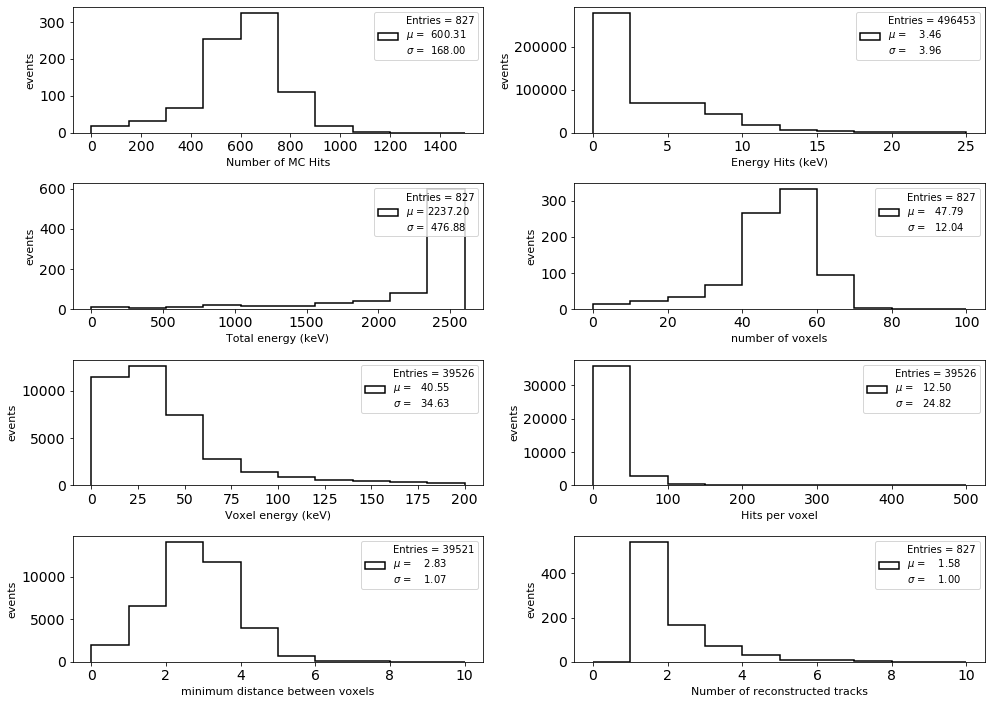

In [137]:
reco_gtrack_stats_histos(trs,rNumberMCHits      = (0,1500),
                             rEnergyMCHits      = (0,25),
                             rTotalEnergyMCHits = (0,2600),
                             rNumberOfVoxels    = (0,100),
                             rVoxelEnergyKeV    = (0,200),
                             rHitsPerVoxel      = (0,500),
                             rMinimumDistVoxels = (0,10),
                             rNumberRecTrks     = (0,10),
                             figsize            = (14,10))

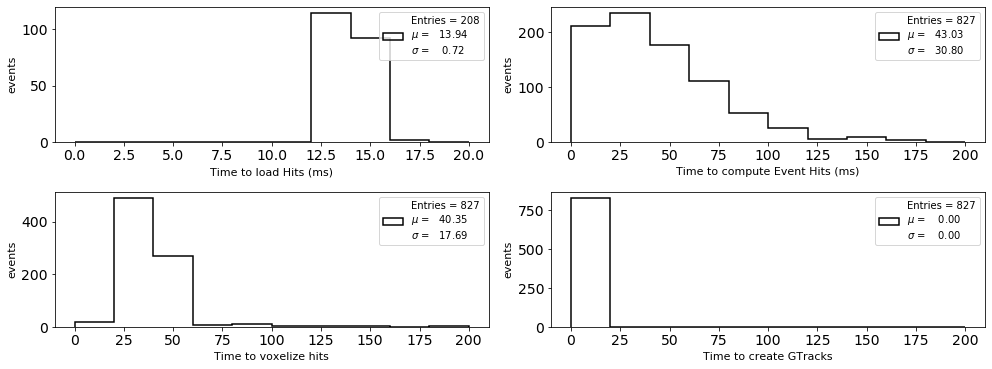

In [84]:
reco_gtrack_timing_histos(trt, figsize=(14,10))

### Blobs

In [85]:
gts = reco_gtrack_blobs(gtrks, rb = 5)

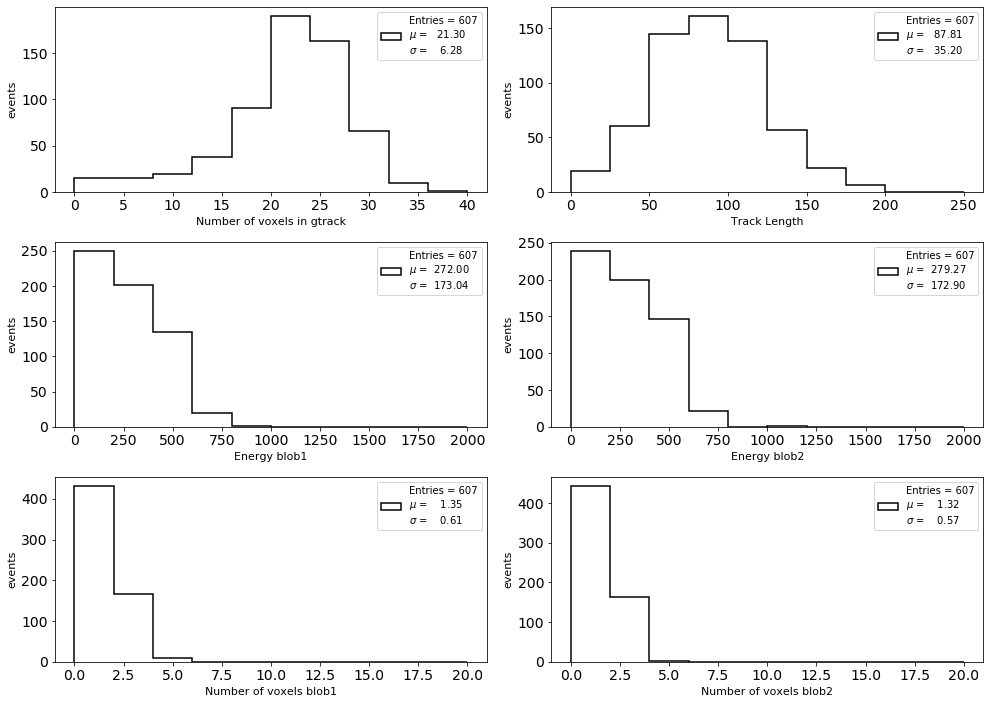

In [86]:
reco_gtrack_blobs_histos(gts, figsize=(14,10))

In [87]:
gts = reco_gtrack_blobs(gtrks, rb = 10)

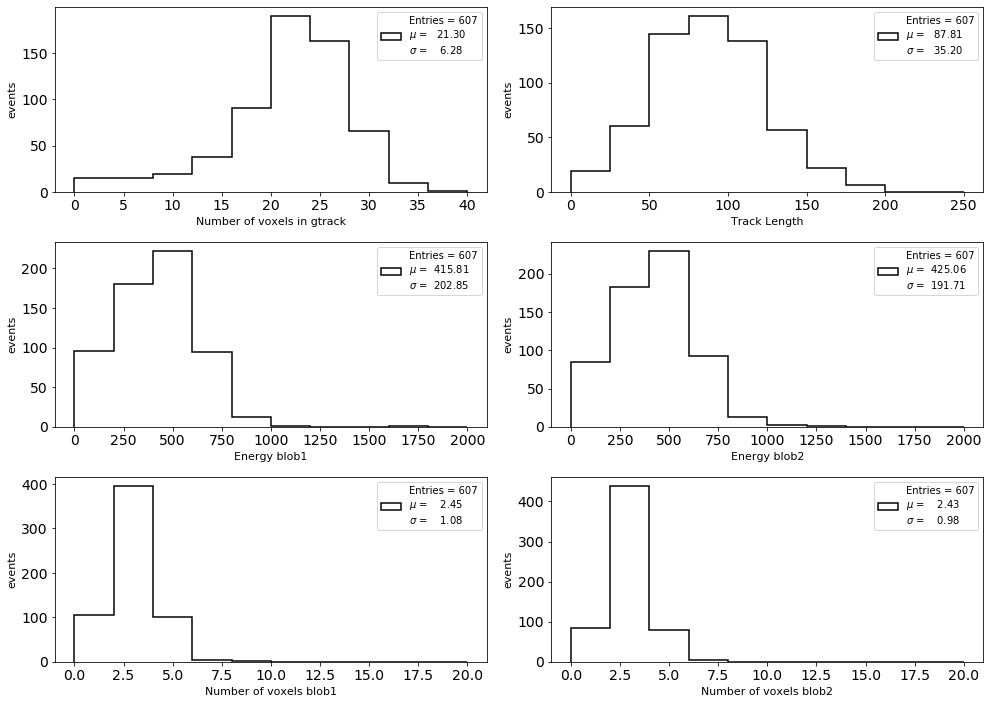

In [88]:
reco_gtrack_blobs_histos(gts, figsize=(14,10))

In [89]:
gts = reco_gtrack_blobs(gtrks, rb = 15)

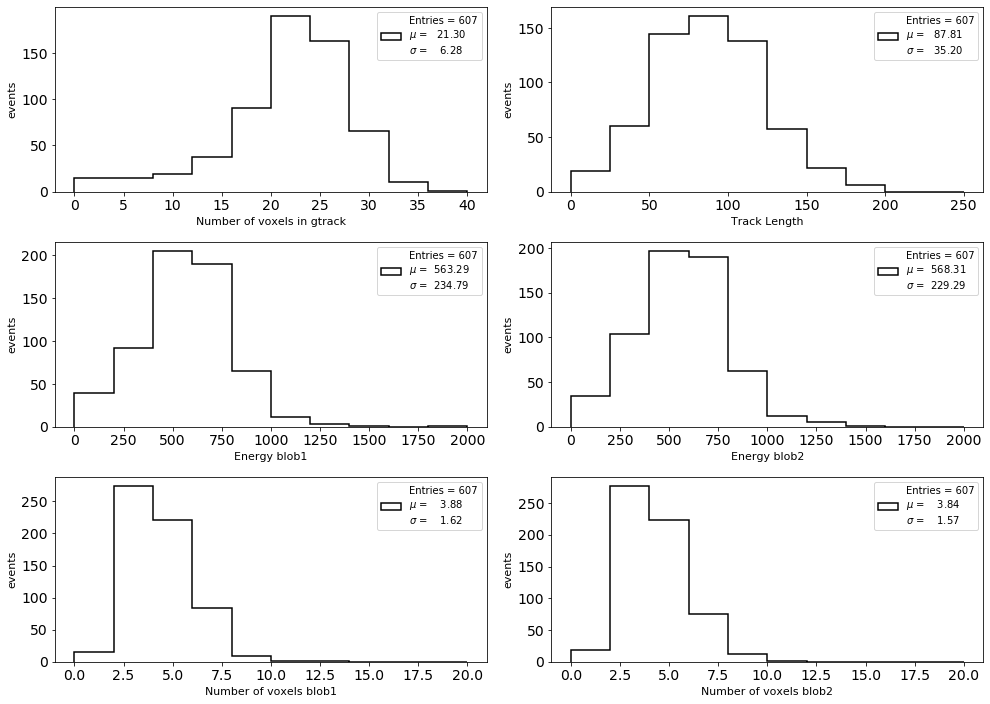

In [90]:
reco_gtrack_blobs_histos(gts, figsize=(14,10))

In [91]:
gts = reco_gtrack_blobs(gtrks, rb = 20)

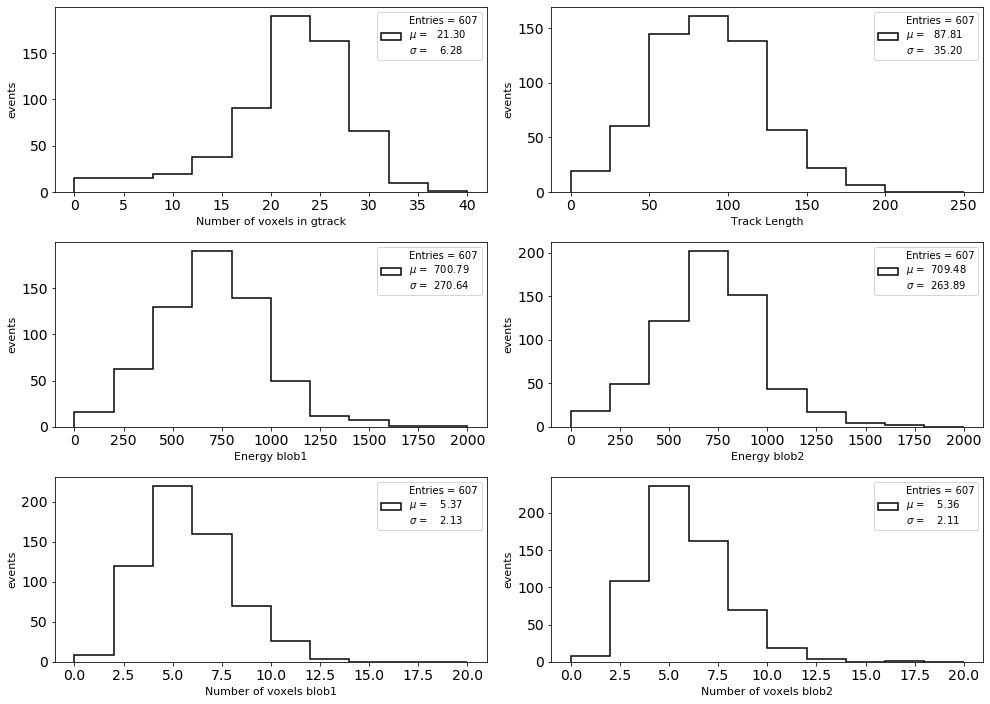

In [92]:
reco_gtrack_blobs_histos(gts, figsize=(14,10))

### Display a few events

In [138]:
gts = reco_gtrack_blobs(gtrks, rb = 5)

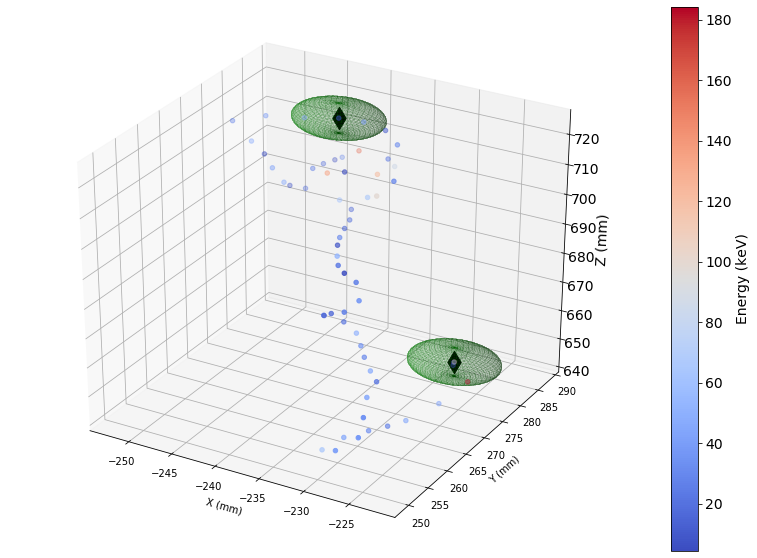

In [139]:
plot_gtrack(gtrks[0],
            rblob     = 5,
            autorange = True,
            weight    = 'energy',
            xrange    = (-500,500),
            yrange    = (-500,500),
            zrange    = (0,1000),
            figsize   = (14,10))

In [140]:
gtrack_summary(gts,0)


    GTrack number = 0
    NumberOfVoxels    = 61
    TrackLength       = 137.4830200590285
    NumberVoxelsBlob1 = 3
    NumberVoxelsBlob2 = 4
    EnergyBlob1       = 94.60117947310209
    EnergyBlob2       = 308.8993430137634
    


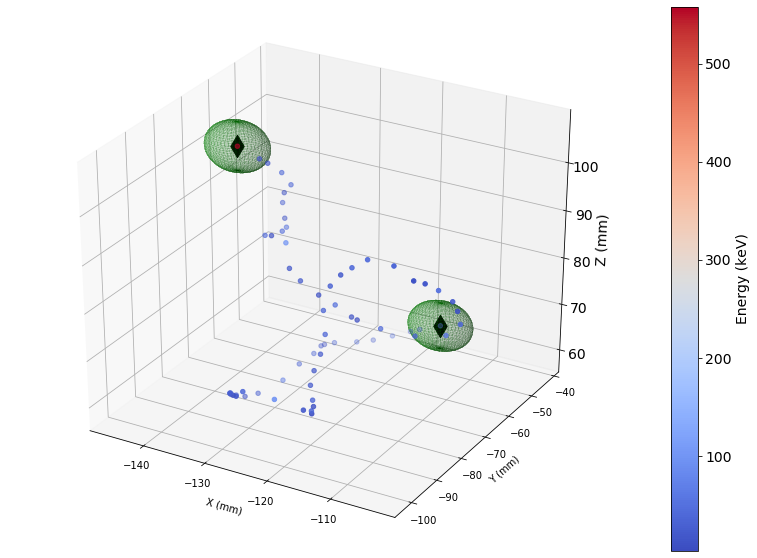

In [141]:
plot_gtrack(gtrks[1], rblob = 5, figsize = (14,10))

In [142]:
gtrack_summary(gts,1)


    GTrack number = 1
    NumberOfVoxels    = 66
    TrackLength       = 144.53077523358277
    NumberVoxelsBlob1 = 2
    NumberVoxelsBlob2 = 2
    EnergyBlob1       = 563.0452358163893
    EnergyBlob2       = 83.12646811828017
    


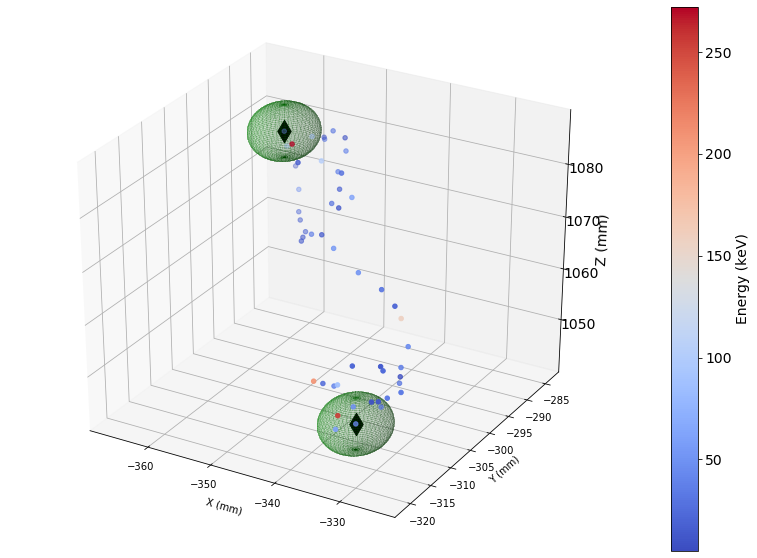

In [143]:
plot_gtrack(gtrks[2], rblob = 5, figsize = (14,10))

In [144]:
gtrack_summary(gts,2)


    GTrack number = 2
    NumberOfVoxels    = 51
    TrackLength       = 67.81015967624582
    NumberVoxelsBlob1 = 2
    NumberVoxelsBlob2 = 2
    EnergyBlob1       = 129.65326383709908
    EnergyBlob2       = 74.64705780148506
    


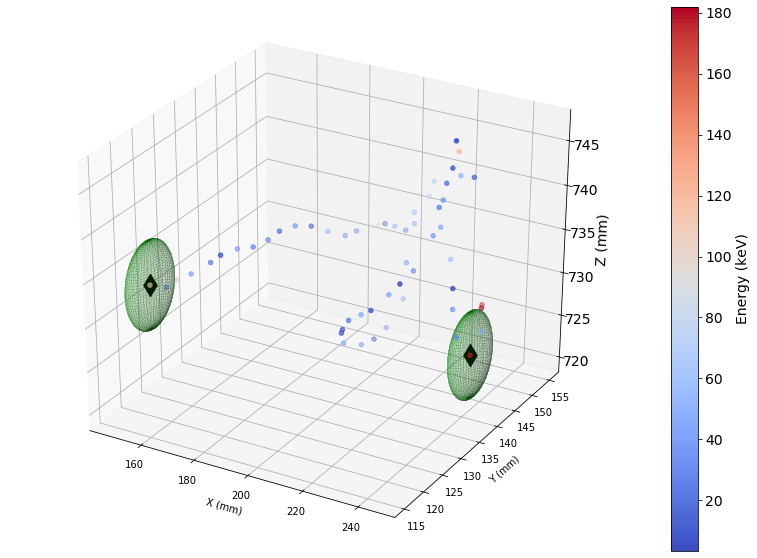

In [145]:
plot_gtrack(gtrks[5], rblob = 5, figsize = (14,10))

In [146]:
gtrack_summary(gts,5)


    GTrack number = 5
    NumberOfVoxels    = 55
    TrackLength       = 131.8967894119271
    NumberVoxelsBlob1 = 2
    NumberVoxelsBlob2 = 3
    EnergyBlob1       = 155.78097850084305
    EnergyBlob2       = 249.3289839476347
    


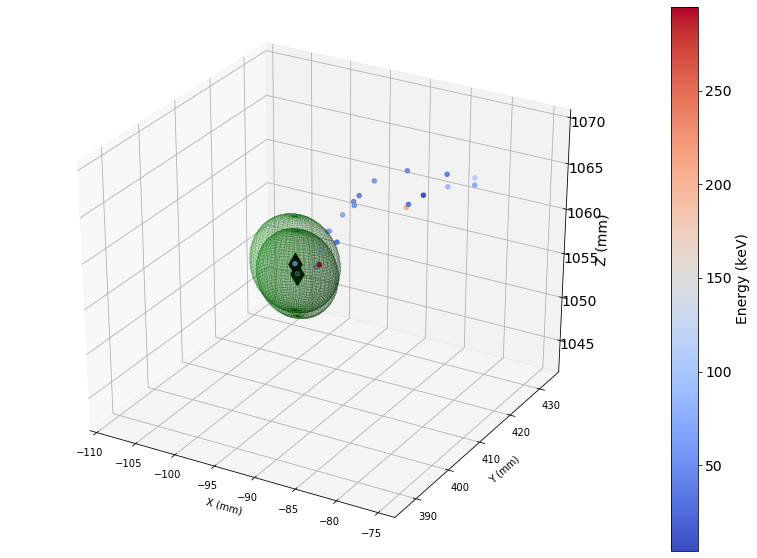

In [147]:
plot_gtrack(gtrks[10], rblob = 5, figsize = (14,10))

In [148]:
gtrack_summary(gts,10)


    GTrack number = 10
    NumberOfVoxels    = 22
    TrackLength       = 66.75516580203856
    NumberVoxelsBlob1 = 1
    NumberVoxelsBlob2 = 2
    EnergyBlob1       = 98.64409267902374
    EnergyBlob2       = 342.8700715303421
    
